<a href="https://colab.research.google.com/github/JuanSpecht/PDI2021/blob/main/TP6/PDI_TP6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PDI - Trabajo Práctico 6: Convolución

## Importo las bibliotecas necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
import IPython.display as ipd
import seaborn as sns
from google.colab import files

## BACKEND

In [2]:
# Para obtener la n-ésima línea del triángulo de Pascal 
def pascal_triangle(n):

    x = [1,1] # comienzo por la segunda línea prefabricada
    for line in range(n-2):
        x.extend([1])
        x_new = x.copy()
        for i in range(len(x)-2):
            x_new[i+1] = x[i] + x[i+1]
        x = x_new
    return x

# Defino los kernels
def kernel_maker(kernel):

    if kernel['name'] == 'Plano':
        size = int(kernel['option'])
        kernel['array'] = np.ones((size,size))
        
    elif kernel['name'] == 'Bartlett':
        size = int(kernel['option'])
        x = np.zeros(size)
        for i in range(len(x)):
            x[i]=-np.abs(i+1-np.ceil(size/2))+np.ceil(size/2)
        y = x.copy()
        kernel['array'] = np.outer(x,y)

    elif kernel['name'] == 'Gaussiano':
        size = int(kernel['option'])
        x = pascal_triangle(size)
        y = x.copy()
        kernel['array'] = np.outer(x,y)

    elif kernel['name'] == 'Laplaciano':
        laplacian_type = kernel['option']
        if laplacian_type == 'v4':
            kernel['array'] = np.full((3,3), -1)
            kernel['array'][0,0] = kernel['array'][0,2] = kernel['array'][2,0] = kernel['array'][2,2] = 0
            kernel['array'][1,1] = 4
        elif laplacian_type == 'v8':
            kernel['array'] = np.pad(np.array([[8]]), 1, constant_values=-1)

    elif kernel['name'] == 'Sobel':
        # prefabrico el de 0º y el de 45º
        sobel_0 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        sobel_45 = np.array([[0,1,2],[-1,0,1],[-2,-1,0]])
        # armo los restantes aplicando rotaciones
        direction = kernel['option']
        if direction == '0°':
            kernel['array'] = sobel_0
        elif direction == '45°':
            kernel['array'] = sobel_45
        elif direction == '90°':
            kernel['array'] = np.rot90(sobel_0)
        elif direction == '135°':
            kernel['array'] = np.rot90(sobel_45)
        elif direction == '180°':
            kernel['array'] = np.rot90(sobel_0,2)
        elif direction == '225°':
            kernel['array'] = np.rot90(sobel_45,2)
        elif direction == '270°':
            kernel['array'] = np.rot90(sobel_0,3)
        elif direction == '315°':
            kernel['array'] = np.rot90(sobel_45,3)

    elif kernel['name'] == 'Paso banda':
        # Defino el bartlett con padding
        size = 3
        x = np.zeros(size)
        for i in range(len(x)):
            x[i]=-np.abs(i+1-np.ceil(size/2))+np.ceil(size/2)
        y = x.copy()
        bartlett_kernel = np.pad(16*np.outer(x,y), 1)
        # Defino el gaussiano
        x = pascal_triangle(5)
        y = x.copy()
        gaussian_kernel = np.outer(x,y)
        # Realizo la resta
        kernel['array'] = bartlett_kernel - gaussian_kernel

    elif kernel['name'] == 'Paso alto':
        # Elijo los valores 16 y 48 en los centros para que la ganancia sea nula
        frec = kernel['option']
        if frec == '0.2':
            kernel['array'] = np.pad(np.pad(np.array([[48]]), 1, constant_values=-4), 1, constant_values=-1)
        elif frec == '0.4':
            kernel['array'] = np.pad(np.pad(np.array([[16]]), 1, constant_values=-4), 1, constant_values=1)

    return kernel['array']
    
# Para hacer la convolución
def convolve (img, ker):
    pad = int(np.floor(np.shape(ker)[0]/2))
    padded_img = np.pad(img, pad)
    # Normalizo para que la ganancia sea 1 en los casos en que corresponde
    coef_sum = np.sum(ker)
    if coef_sum != 0:
        ker = ker/coef_sum
    # Realizo la convolución
    conv = np.empty_like(ker)
    output_img = np.empty_like(img)
    for i in range(np.shape(img)[0]):
        try: # para que funcione fuera de la instancia View
            View.progress_bar.value = i/np.shape(img)[0]
            View.progress_bar.description = str(int(100 * i/np.shape(img)[0])) + ' %'
        except:
            pass
        for j in range(np.shape(img)[1]):
            for k in range(np.shape(ker)[0]):
                for l in range(np.shape(ker)[1]):
                    conv[k,l] = padded_img[i+k,j+l]*ker[k,l]
            output_img[i,j] = np.clip(np.sum(conv),0,255)

    return output_img

## FRONTEND

In [77]:
class ConvUI:

    def __init__(self):
        # Creo la caja donde van los sliders
        self.dropdown_box = widgets.HBox(layout=widgets.Layout(
            height='50px',
            align_items='center',))

        self.par = dict()
        self.par['kernel'] = dict()
        self.disclaimer = "*Los elementos del kernel se muestran sin normalizar \
        por comodidad, pero para hacer los cálculos se utilizan normalizados."
        
        self.initUI()

    def initUI(self):
        # Inicializo las funciones que manejan los widgets
        self.initKernelOptionsDropdown()
        self.initKernelNameDropdown()
        self.initLoadButton()
        self.initSaveButton() 
        self.initRunButton()
        self.initKernelOutput()
        self.initProgressBar()

        # Armo el layout de la interfaz
        self.controls = widgets.VBox([
            widgets.HBox([self.load_button, self.save_button],
                         layout=widgets.Layout(justify_content='center')),
            self.dropdown_box,            
            widgets.VBox([self.kernel_output,
                          self.run_button, 
                          widgets.HTML(value= '<style>p{word-wrap: break-word}</style> <p>'+
                                       self.disclaimer +' </p>')],
                         layout=widgets.Layout(align_items='center'))],
            layout=widgets.Layout(width='360px',align_items='stretch'))

        self.input_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.output_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.image_panel = widgets.VBox([widgets.HBox([self.input_image,
                                                       self.output_image]),
                                         self.progress_bar]
                                        )
        
        self.UI = widgets.HBox([self.controls,self.image_panel],
                               layout=widgets.Layout(height='520px',
                                                     border='solid 2px'))

    def initLoadButton(self):
        self.load_button = widgets.FileUpload(
            accept='',
            multiple=False,
            description="Abrir imagen"
            )
        
        self.load_button.observe(self.updateInputImage, "value")
    
    def updateInputImage (self, change):
        self.par['input_image'] = Image.open(BytesIO(self.load_button.data[0]))

        with self.input_image:
            ipd.clear_output()
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['input_image'], interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show() 

    def initRunButton(self):
        self.run_button = widgets.Button(description="Aplicar")
        self.run_button.on_click(self.updateOutputImage)
    
    def updateOutputImage(self, change):

        with self.output_image:
            ipd.clear_output()
            
        self.progress_bar.layout.visibility = 'visible'

        img = np.array(self.par['input_image'].convert('L'))
        ker = self.par['kernel']['array']

        self.par['output_image'] = convolve(img, ker)
        
        # Muestro el resultado
        with self.output_image:
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['output_image'], 'gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()
        
        self.progress_bar.layout.visibility = 'hidden'

    def initKernelNameDropdown(self):
        self.kernel_name_dropdown = widgets.Dropdown(
            options=["Plano",
                     "Bartlett",
                     "Gaussiano",
                     "Laplaciano",
                     "Sobel",
                     "Paso banda",
                     "Paso alto"],
                     description='Kernel:', 
                    layout=widgets.Layout(width='max_content',),
                     continuous_update=True)
        
        self.kernel_name_box = widgets.VBox([widgets.Label(value='Kernel:'),
                                             self.kernel_name_dropdown],
                                            )
        
        self.updateKernelName(None)
        self.updateKernelOptions(None)

        self.kernel_name_dropdown.observe(self.updateKernelName, "value")

    def updateKernelName(self, change):
        self.par['kernel']['name'] = self.kernel_name_dropdown.value

        if self.par['kernel']['name'] == "Paso banda":
            self.dropdown_box.children = [self.kernel_name_dropdown]

        else:
            self.dropdown_box.children = [self.kernel_name_dropdown, 
                                          self.kernel_options_dropdown]
                                          
            if self.par['kernel']['name'] == "Plano":
                self.kernel_options_dropdown.description = 'Tamaño:'
                self.kernel_options_dropdown.options = ['3', '5', '7']
            
            elif self.par['kernel']['name'] == "Bartlett":
                self.kernel_options_dropdown.description = 'Tamaño:'
                self.kernel_options_dropdown.options = ['3', '5', '7']
            
            elif self.par['kernel']['name'] == "Gaussiano":
                self.kernel_options_dropdown.description = 'Tamaño:'
                self.kernel_options_dropdown.options = ['5', '7']
            
            elif self.par['kernel']['name'] == "Laplaciano":
                self.kernel_options_dropdown.description = 'Tipo:'
                self.kernel_options_dropdown.options = ["v4", "v8"]
            
            elif self.par['kernel']['name'] == "Sobel":
                self.kernel_options_dropdown.description = 'Dirección:'
                self.kernel_options_dropdown.options = ["0°", "45°", "90°", "135°", 
                                                        "180°", "225°", "270°", "315°"]
            
            elif self.par['kernel']['name'] == "Paso alto":
                self.kernel_options_dropdown.description = 'Frecuencia:'
                self.kernel_options_dropdown.options = ['0.2', '0.4']
        try:
            self.plotKernel(None)
        except:
            pass
    
    def initKernelOptionsDropdown(self):
        self.kernel_options_dropdown = widgets.Dropdown(
            layout=widgets.Layout(width='max_content',
                                  ),
                                  continuous_update=True)
        self.options_label = widgets.Label()
        self.kernel_options_box = widgets.VBox([self.options_label,
                                             self.kernel_options_dropdown])

        self.kernel_options_dropdown.observe(self.updateKernelOptions, "value")

    def updateKernelOptions(self, change):
        # 'option' es un parámetro diferente para cada tipo de kernel
        self.par['kernel']['option'] = self.kernel_options_dropdown.value

        try:
            self.plotKernel(None)
        except:
            pass

    def initKernelOutput(self):
        self.kernel_output = widgets.Output(layout=widgets.Layout(
            width='280px',
            height='280px',
            border='solid 2px',
            )
        )
        
        self.plotKernel(None)    

    def plotKernel(self, change):
        try:
            self.par['kernel']['array'] = kernel_maker(self.par['kernel'])
            with self.kernel_output:
                ipd.clear_output()
                colormap=sns.diverging_palette(10, 240)
                fig, ax = plt.subplots(figsize=(5,5))
                ax=sns.heatmap(self.par['kernel']['array'], square=True, annot = self.par['kernel']['array'],
                            fmt='.0f', linewidths = 1, cbar=False, cmap=colormap, 
                            center=0, annot_kws={"size": 35 / np.sqrt(len(self.par['kernel']['array']))})
                plt.Axes(fig, [0,0,1,1])
                plt.axis('off')
                plt.show()    
        except:
            pass

    def initSaveButton(self):
        self.save_button = widgets.Button(description="Guardar resultado")
        self.save_button.on_click(self.saveImage)

    def saveImage(self,change):
        img_to_save = Image.fromarray(np.uint8(self.par["output_image"]))
        output_filename = self.par['kernel']['name'] + self.par['kernel']['option'] + '.jpg'
        img_to_save.save(output_filename)
        print('La imagen ha sido guardada como ' + '\'' + output_filename + '\'.')

    def initProgressBar(self):
        self.progress_bar = widgets.FloatProgress(
            value=0,
            min=0,
            max=1,
            bar_style='info',
            style={'bar_color': 'green'},
            orientation='horizontal',
            layout=widgets.Layout(width='max_content',
                                  visibility = 'hidden')
        )
        
    def _ipython_display_(self):
        display(self.UI)

View = ConvUI()
View

## Comparación de los diferentes filtros sobre una misma imagen

### Cargo la imagen

In [57]:
uploaded = files.upload()
keys_list = list(uploaded)
key = keys_list[0]
img = Image.open(BytesIO(uploaded[key]))

Saving The_Earth_seen_from_Apollo_17_320px.tif to The_Earth_seen_from_Apollo_17_320px (1).tif


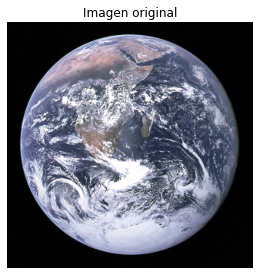

In [58]:
fig, ax = plt.subplots()
fig.tight_layout()
ax.title.set_text('Imagen original')
ax.imshow(img, 'gray')
ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

### Hago los filtrados

In [17]:
kernels = {0: ["Plano","3"], 1: ["Plano","5"], 2: ["Plano","7"],
           3: ["Bartlett","3"], 4: ["Bartlett","5"], 5: ["Bartlett","7"],
           6: ["Gaussiano","5"], 7: ["Gaussiano","7"],
           8: ["Laplaciano","v4"], 9: ["Laplaciano","v8"],
           10: ["Sobel","0°"], 11: ["Sobel","45°"], 12: ["Sobel","90°"], 13: ["Sobel","135°"], 
           14: ["Sobel","180°"], 15: ["Sobel","225°"], 16: ["Sobel","270°"], 17: ["Sobel","315°"],
           18: ["Paso banda","foo"], 19: ["Paso alto","0.2"], 20: ["Paso alto","0.4"]}

progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=1,
    bar_style='info',
    style={'bar_color': 'green'},
    orientation='horizontal',
    layout=widgets.Layout(width='max_content',
                            visibility = 'hidden')
)
display(progress_bar)
img_gray = np.array(Image.open(BytesIO(uploaded[key])).convert('L'))
kernel = dict()
convos = dict()
progress_bar.layout.visibility = 'visible'
for i in range(21):
    progress_bar.value = i/21
    progress_bar.description = str(int(100 * i/21)) + ' %'
    kernel['name'] = kernels[i][0]
    kernel['option'] = kernels[i][1]
    ker = kernel_maker(kernel)
    convos[i] = convolve (img_gray, ker)
progress_bar.layout.visibility = 'hidden'

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden', width='max_content'), max=1.0, s…

## Filtros paso bajo

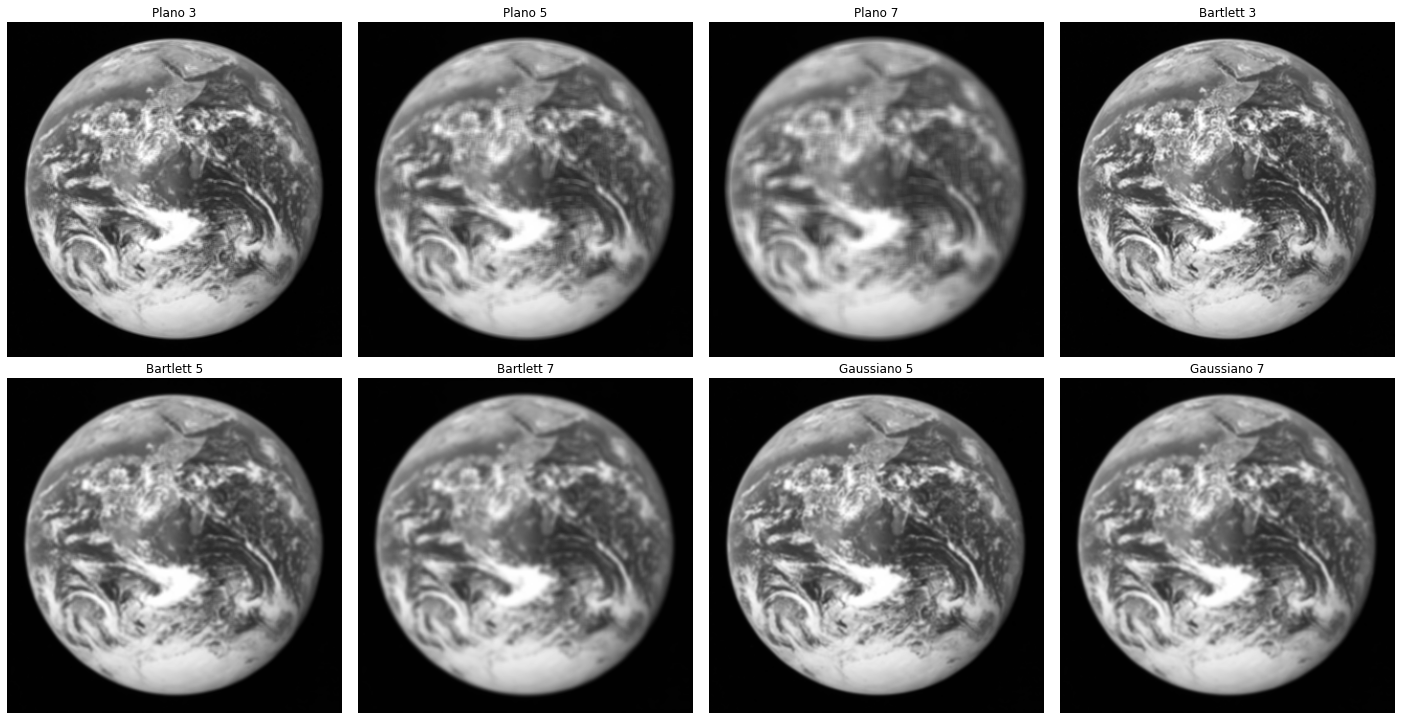

In [61]:
fig, axs = plt.subplots(2,4,figsize=(20,10.25))
fig.tight_layout()
axs = axs.ravel()
for i in range(8):
    axs[i+10].title.set_text(kernels[i+10][0] + ' ' + kernels[i+10][1])
    axs[i+10].imshow(convos[i+10], 'gray')
    axs[i+10].axis('off')
axs = axs.reshape(2,4)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

* Observando la imagen filtrada con los distintos filtros paso bajo, vemos que se destruye información de alta frecuencia. A mayor tamaño del kernel, el umbral de frecuencia es más bajo (sobreviven menos frecuencias), por lo tanto la imagen resultante se ve más difuminada.
* Comparando los distintos tipos de filtro a igual tamaño de kernel, se ve que el plano es más agresivo que el Bartlett y este a su vez es mas agresivo que el gaussiano. Esto tiene que ver con la forma de los respectivos filtros en dominio de la frecuencia, donde una función más ancha deja pasar más frecuencias que una mas angosta.

## Filtros paso alto

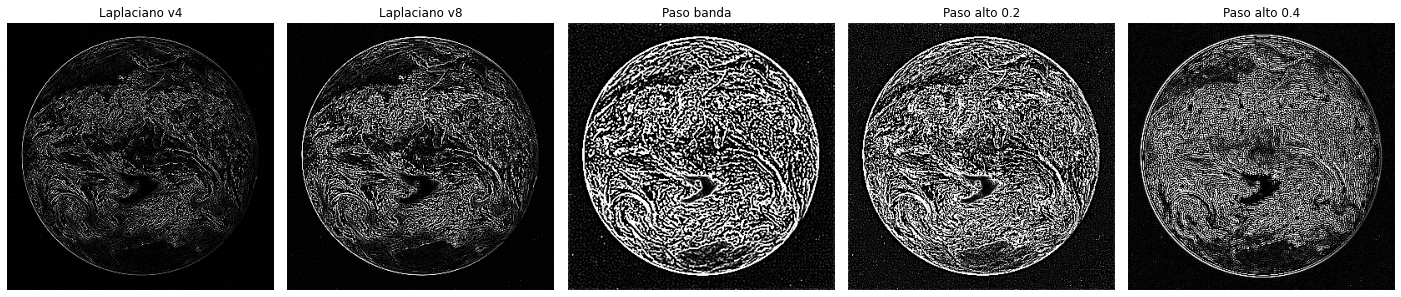

In [72]:
fig, axs = plt.subplots(1,5,figsize=(20,10.25))
fig.tight_layout()
for i in range(8,10):
    axs[i-8].title.set_text(kernels[i][0] + ' ' + kernels[i][1])
    axs[i-8].imshow(convos[i], 'gray')
    axs[i-8].axis('off')
for i in range(18,21):
    axs[i-16].title.set_text(kernels[i][0] + ' ' + kernels[i][1])
    axs[i-16].imshow(convos[i], 'gray')
    axs[i-16].axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

* Los filtros paso alto resaltan las características de alta frecuencia de la imagen (por ejemplo, los bordes entre regiones claras y oscuras).

* Para la imagen utilizada, se ve una diferencia marcada entre el fondo y la Tierra. El fondo, donde no hay mucha información de alta frecuencia, se mantiene relativamente oscuro luego del filtro, mientras que la Tierra, donde hay más información en las frecuencias altas, queda resaltada en el filtrado (excepto algunas zonas donde hay un blanco sólido por las nubes).

* Con el `Paso banda` se resaltan las estrellas y el ruido de fondo, al igual que con el `Paso alto 0.2`. El `Paso alto 0.4`, al tener un umbral de frecuencias más alto, elimina esta información.

## Filtros direccionales

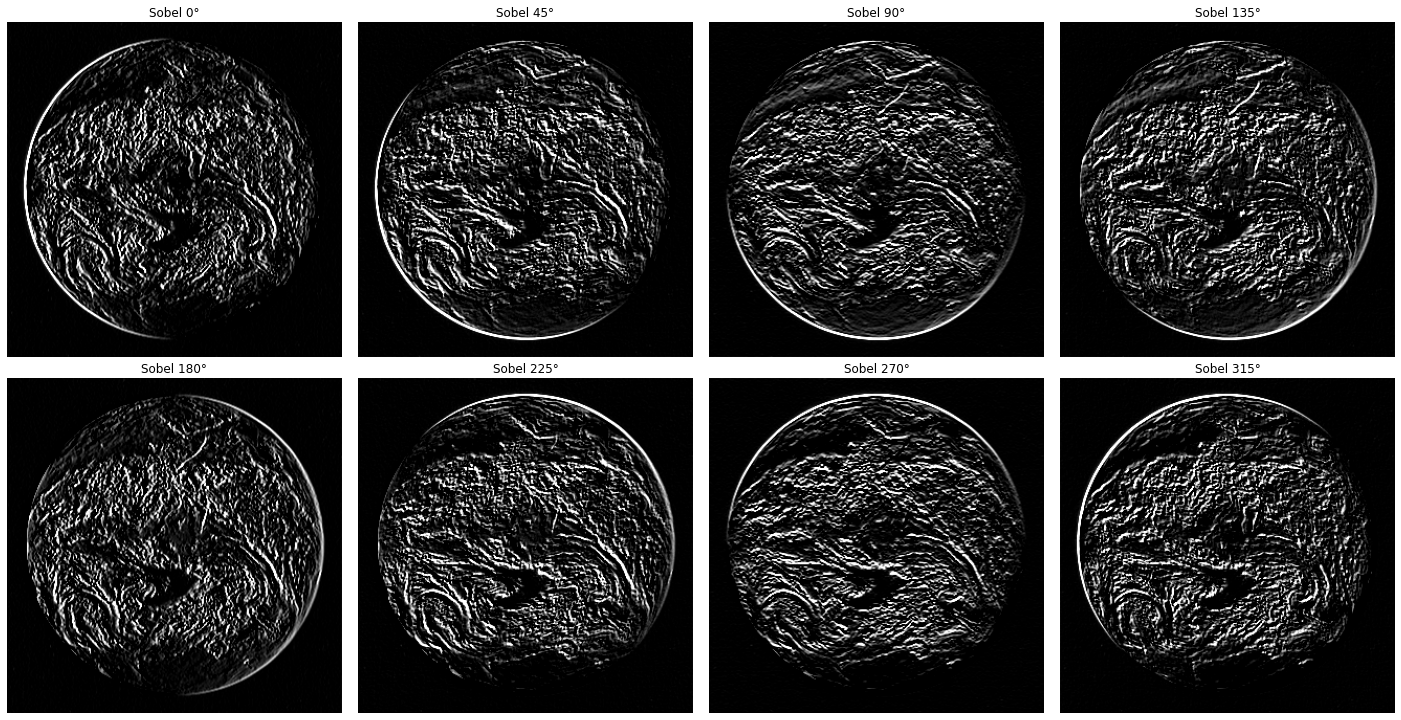

In [67]:
fig, axs = plt.subplots(2,4,figsize=(20,10.25))
fig.tight_layout()
axs = axs.ravel()
for i in range(10,18):
    axs[i-10].title.set_text(kernels[i][0] + ' ' + kernels[i][1])
    axs[i-10].imshow(convos[i], 'gray')
    axs[i-10].axis('off')
axs = axs.reshape(2,4)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

* Los filtros Sobel, al igual que los paso alto, resaltan las fronteras entre regiones claras y oscuras, con la diferencia de que sólo marcan los bordes donde la imagen pasa de una región oscura a una más luminosa en una dirección específica.

* En la imagen utilizada, esto se ve claramente en los bordes entre la Tierra y el fondo. Por ejemplo, con la dirección 0º (paso de oscuro a claro de izquierda a derecha), aparece un borde blanco del lado izquierdo de la Tierra.